# Compare SNA and SNA Riccati, should be the identical

In [1]:
import numpy as np
from functools import partial

from simulation import Simulation
from objective_functions import LogisticRegression, LinearRegression
from datasets import generate_logistic_regression, generate_linear_regression
from optimization_algorithms import SNA, SNARiccati, WASNA, WASNARiccati

N = 20
n = int(1e4)

true_theta = np.array([0, 3, -9, 4, -9, 15, 0, -7, 1, 0])  # Set bias=True
bias_setting = True

e = 1.0

optimizer_list = [
    SNA(nu=1.0),
    SNARiccati(nu=1.0),
    WASNA(nu=0.75),
    WASNARiccati(nu=0.75),
    WASNA(nu=1.0),
    WASNARiccati(nu=1.0),
]

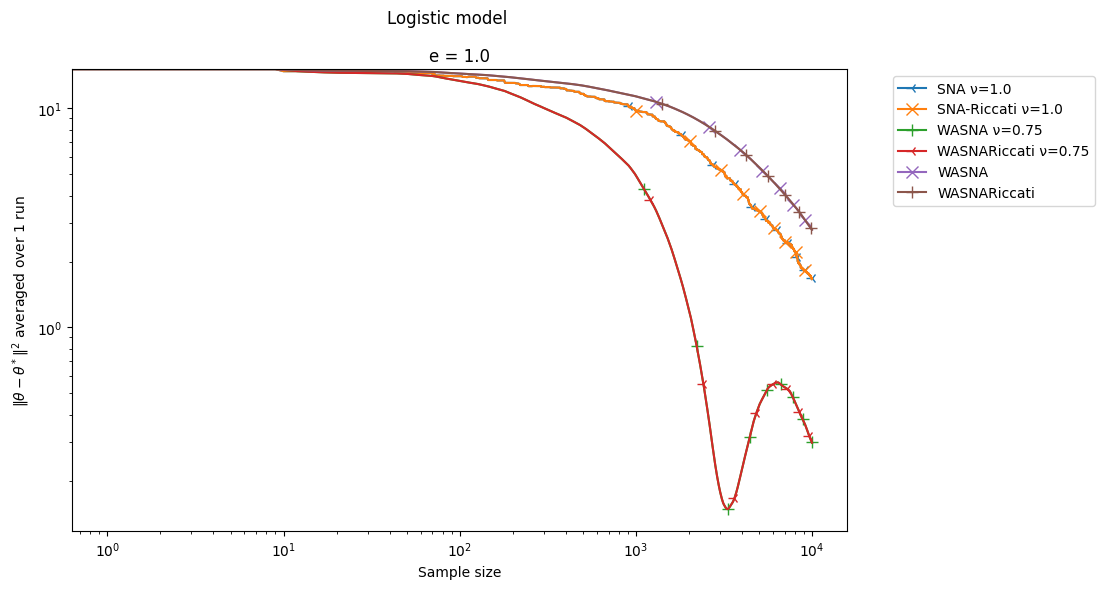

In [2]:
objective_function = LogisticRegression(bias=bias_setting)
simulation = Simulation(
    objective_function,
    optimizer_list,
    e,
    true_theta=true_theta,
    generate_dataset=partial(generate_logistic_regression, bias=bias_setting),
)

# One run
simulation.dataset = simulation.generate_dataset(n, true_theta)
simulation.generate_initial_theta()
_, _ = simulation.run(plot=True)

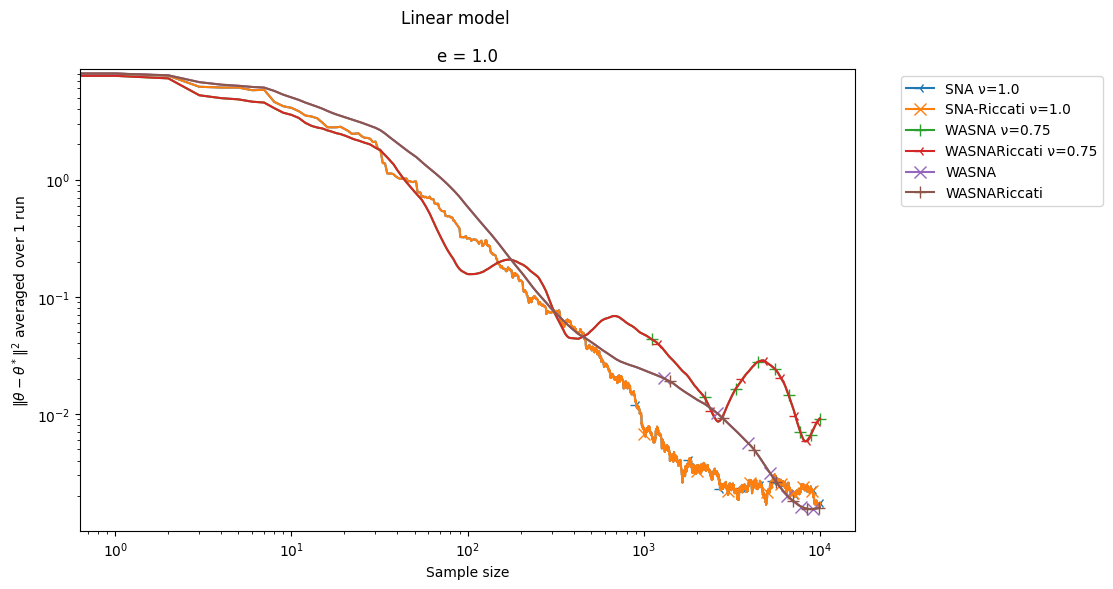

In [3]:
objective_function = LinearRegression(bias=bias_setting)
simulation = Simulation(
    objective_function,
    optimizer_list,
    e,
    true_theta=true_theta,
    generate_dataset=partial(generate_linear_regression, bias=bias_setting),
)

# One run
simulation.dataset = simulation.generate_dataset(n, true_theta)
simulation.generate_initial_theta()
_, _ = simulation.run(plot=True)

# Compare canonical Z and canonical deterministic Z, should be close

## USNA

In [4]:
from optimization_algorithms import USNA

optimizer_list = [
    USNA(nu=1.0, gamma=0.5, generate_Z="normal"),
    USNA(nu=1.0, gamma=0.5, generate_Z="canonic"),
    USNA(nu=1.0, gamma=0.5, generate_Z="canonic deterministic"),
    USNA(nu=1.0, gamma=1.0, generate_Z="normal"),
    USNA(nu=1.0, gamma=1.0, generate_Z="canonic"),
    USNA(nu=1.0, gamma=1.0, generate_Z="canonic deterministic"),
]

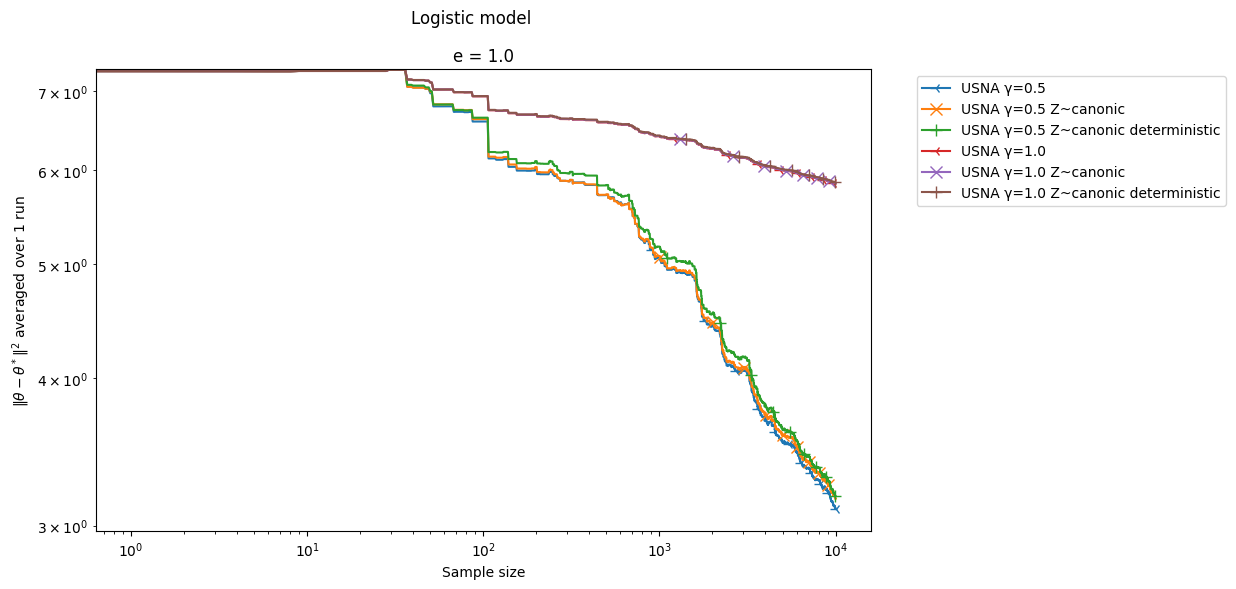

In [5]:
objective_function = LogisticRegression(bias=bias_setting)
simulation = Simulation(
    objective_function,
    optimizer_list,
    e,
    true_theta=true_theta,
    generate_dataset=partial(generate_logistic_regression, bias=bias_setting),
)

# One run
simulation.dataset = simulation.generate_dataset(n, true_theta)
simulation.generate_initial_theta()
_, _ = simulation.run(plot=True)

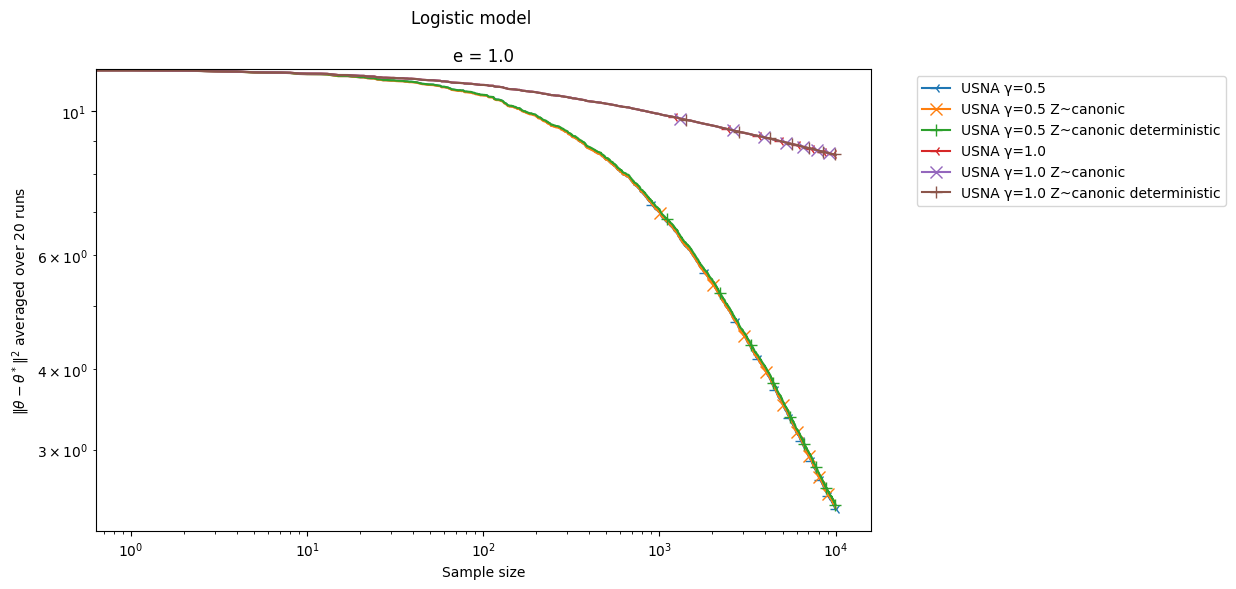

In [6]:
simulation.run_multiple_datasets(N=N, n=n)

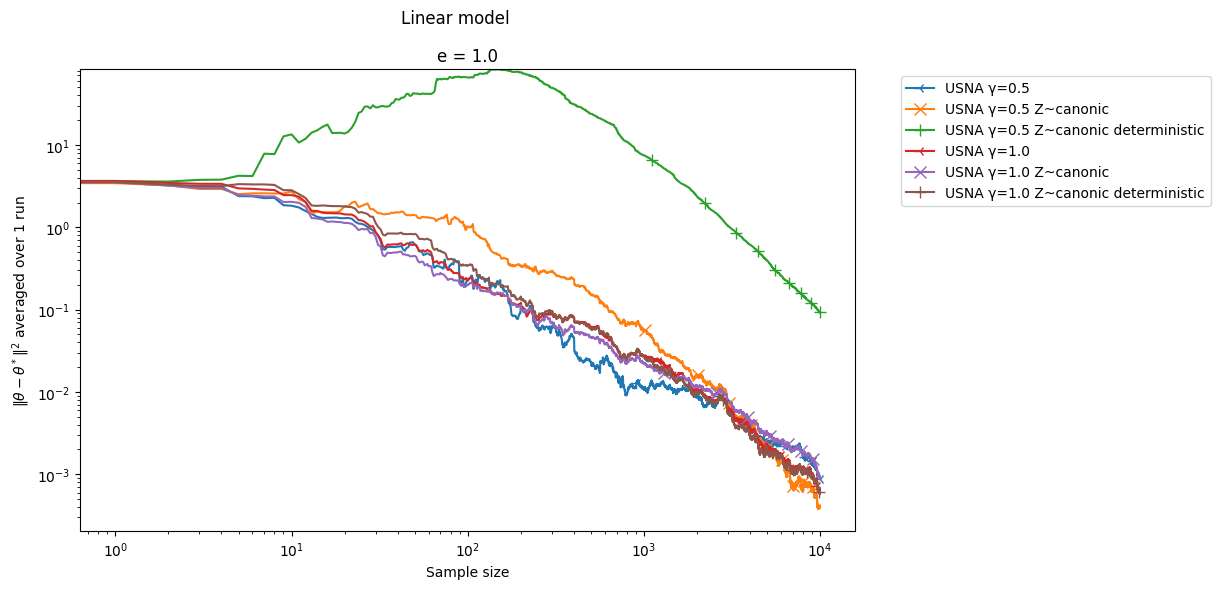

In [7]:
objective_function = LinearRegression(bias=bias_setting)
simulation = Simulation(
    objective_function,
    optimizer_list,
    e,
    true_theta=true_theta,
    generate_dataset=partial(generate_linear_regression, bias=bias_setting),
)

# One run
simulation.dataset = simulation.generate_dataset(n, true_theta)
simulation.generate_initial_theta()
_, _ = simulation.run(plot=True)

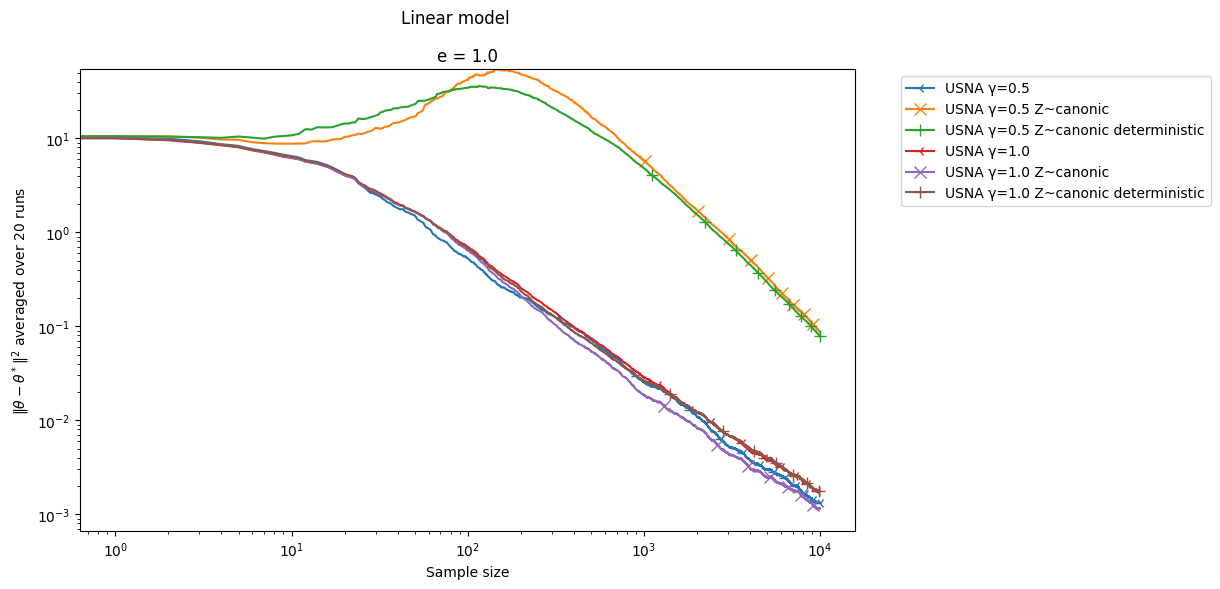

In [8]:
simulation.run_multiple_datasets(N=N, n=n)

## UWASNA

In [9]:
from optimization_algorithms import UWASNA

optimizer_list = [
    UWASNA(nu=1.0, gamma=0.5, generate_Z="normal"),
    UWASNA(nu=1.0, gamma=0.5, generate_Z="canonic"),
    UWASNA(nu=1.0, gamma=0.5, generate_Z="canonic deterministic"),
    UWASNA(nu=1.0, gamma=1.0, generate_Z="normal"),
    UWASNA(nu=1.0, gamma=1.0, generate_Z="canonic"),
    UWASNA(nu=1.0, gamma=1.0, generate_Z="canonic deterministic"),
]

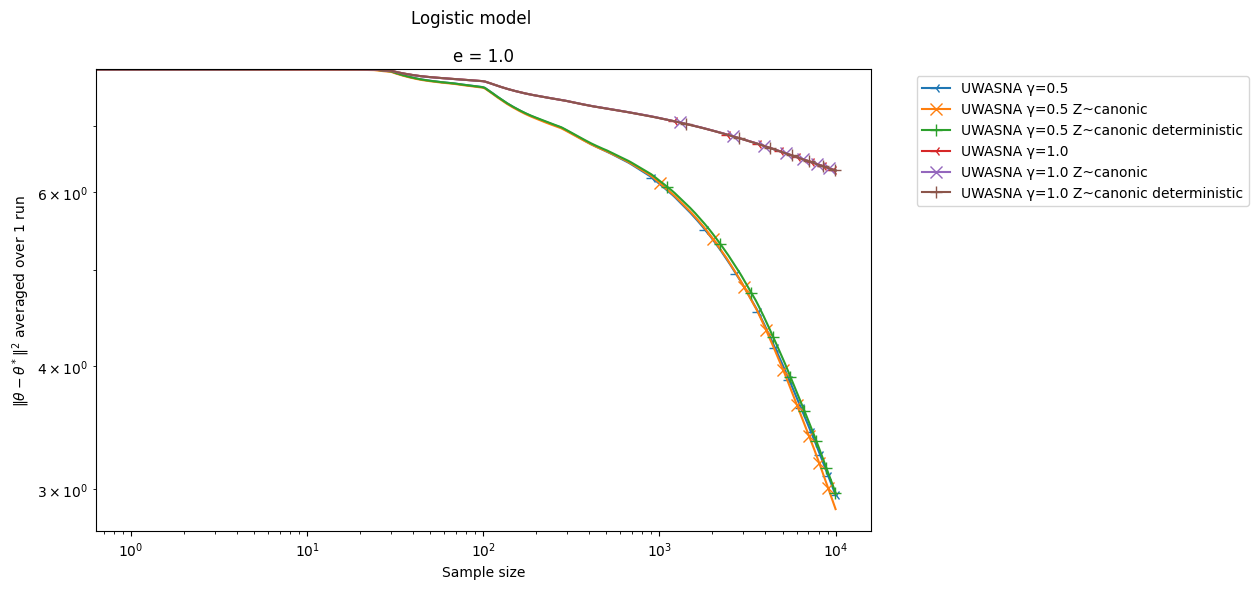

In [10]:
objective_function = LogisticRegression(bias=bias_setting)
simulation = Simulation(
    objective_function,
    optimizer_list,
    e,
    true_theta=true_theta,
    generate_dataset=partial(generate_logistic_regression, bias=bias_setting),
)

# One run
simulation.dataset = simulation.generate_dataset(n, true_theta)
simulation.generate_initial_theta()
_, _ = simulation.run(plot=True)

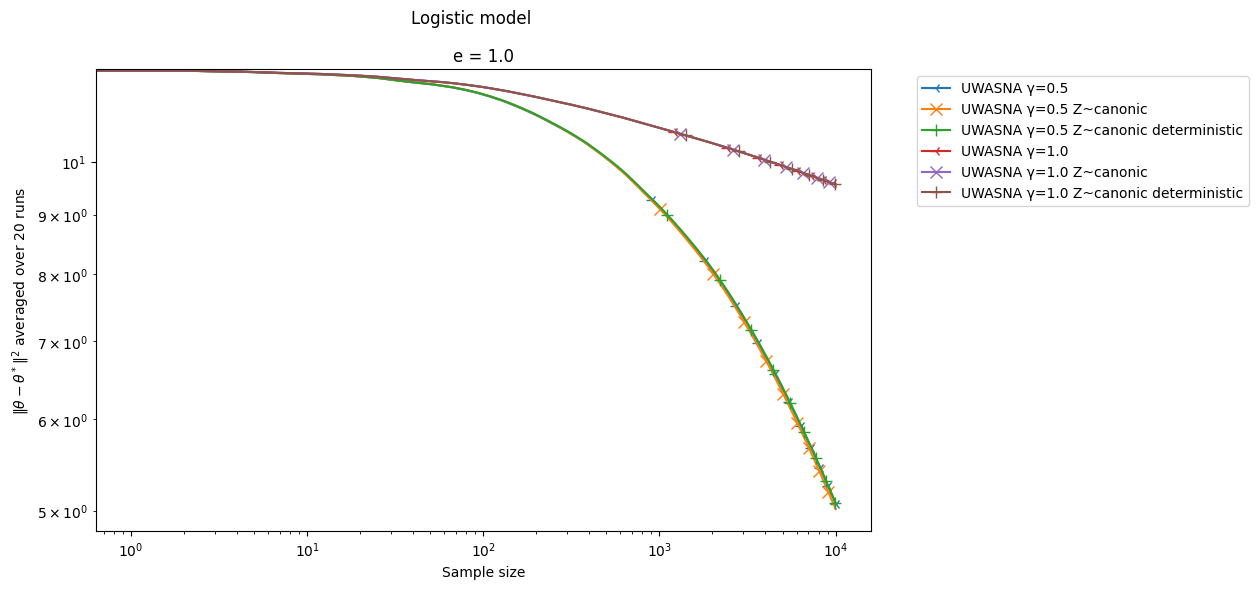

In [11]:
simulation.run_multiple_datasets(N=N, n=n)

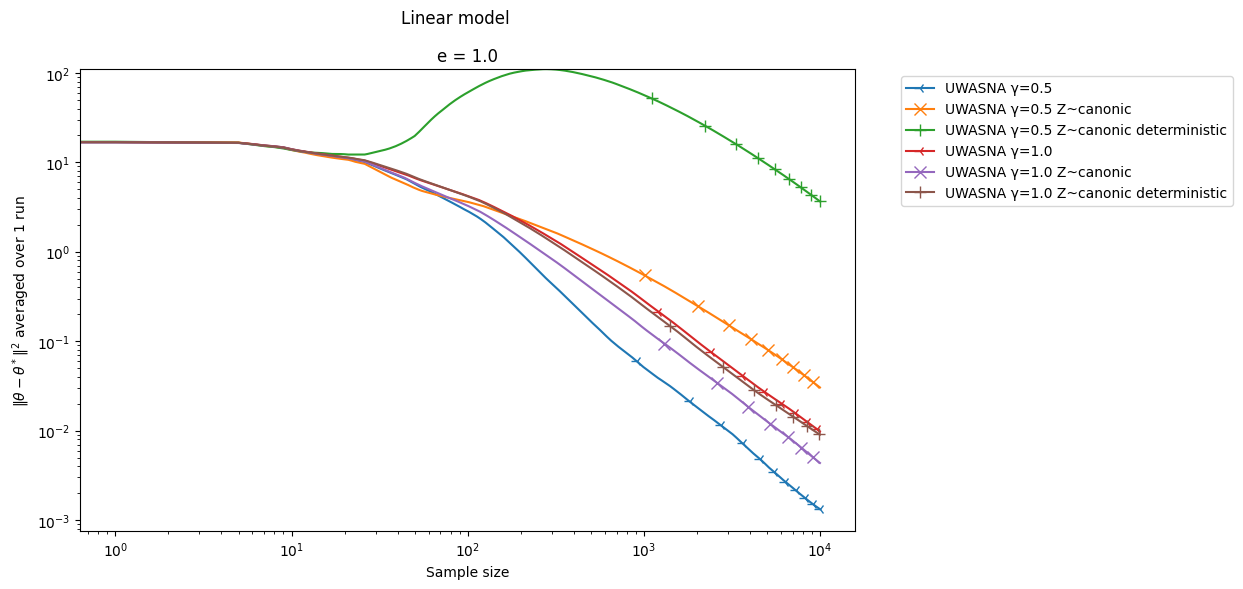

In [12]:
objective_function = LinearRegression(bias=bias_setting)
simulation = Simulation(
    objective_function,
    optimizer_list,
    e,
    true_theta=true_theta,
    generate_dataset=partial(generate_linear_regression, bias=bias_setting),
)

# One run
simulation.dataset = simulation.generate_dataset(n, true_theta)
simulation.generate_initial_theta()
_, _ = simulation.run(plot=True)

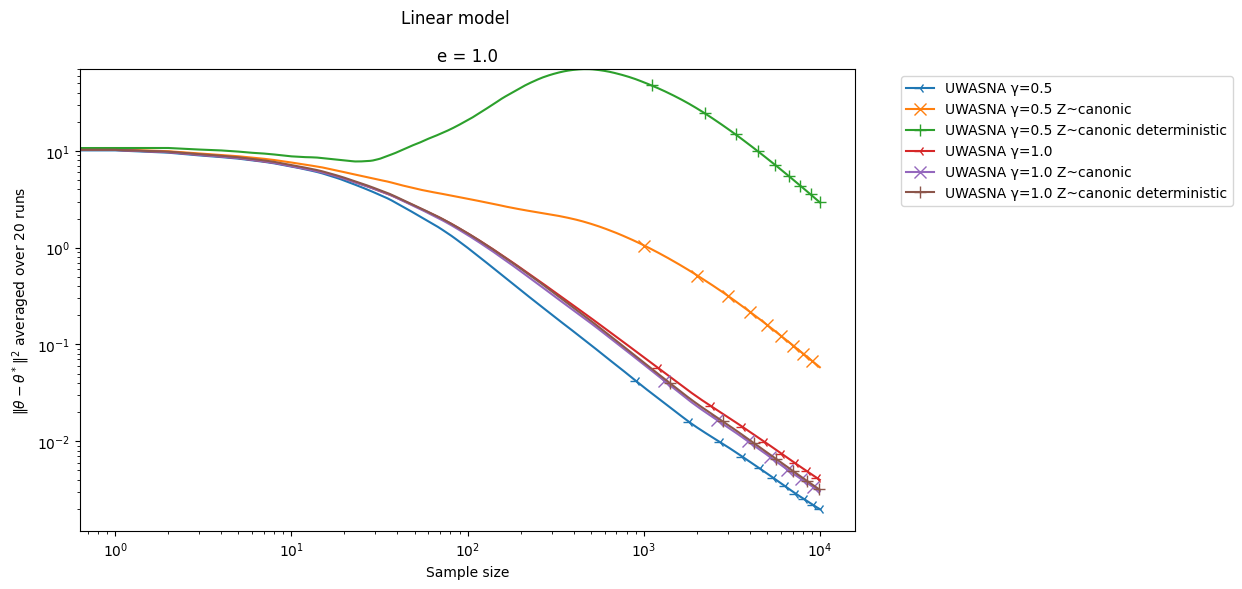

In [13]:
simulation.run_multiple_datasets(N=N, n=n)

# USNA : np.dot VS np.linalg.norm

In [14]:
import numpy as np
import timeit

# Generate random vectors Q and Z of size n
n = 1000  # Example vector size
Q = np.random.rand(n)
Z = np.random.rand(n)

# Define the functions to measure
def dot_product_approach():
    def step(iteration):
        gamma = 1 / iteration
        beta = 1 / (2 * gamma)
        return np.dot(Q, Q) <= beta**2

    for i in range(10_000, 100_000):
        res = step(i)

    return res


def norm_approach():
    def step(iteration):
        gamma = 1 / iteration
        beta = 1 / (2 * gamma)
        return np.linalg.norm(Q) <= beta

    for i in range(10_000, 100_000):
        res = step(i)

    return res


# Measure execution time
dot_time = timeit.timeit(dot_product_approach, number=10)
norm_time = timeit.timeit(norm_approach, number=10)

print("Time using np.dot for squared magnitude: {:.6f} seconds".format(dot_time))
print(
    "Time using np.linalg.norm for squared magnitude: {:.6f} seconds".format(norm_time)
)

Time using np.dot for squared magnitude: 0.616009 seconds
Time using np.linalg.norm for squared magnitude: 1.261167 seconds
